# Some Beautiful codes are from here

https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

https://www.kaggle.com/code/sikaro/catboost-starter-lb-0-67/edit

I really appreciate for every work

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore') # 경고 메시지 생략

df=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
test=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
submission=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv')

TARGETS = df.columns[-6:]
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## Non-overlapping EEG ID TRAIN

In [3]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})

train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp
print(tmp)

            patient_id
eeg_id                
568657           20654
582999           20230
642382            5955
751790           38549
778705           40955
...                ...
4293354003       16610
4293843368       15065
4294455489          56
4294858825        4312
4294958358       25986

[17089 rows x 1 columns]


In [4]:
print(train)

               spec_id     min     max  patient_id
eeg_id                                            
568657       789577333     0.0    16.0       20654
582999      1552638400     0.0    38.0       20230
642382        14960202  1008.0  1032.0        5955
751790       618728447   908.0   908.0       38549
778705        52296320     0.0     0.0       40955
...                ...     ...     ...         ...
4293354003  1188113564     0.0     0.0       16610
4293843368  1549502620     0.0     0.0       15065
4294455489  2105480289     0.0     0.0          56
4294858825   657299228     0.0    12.0        4312
4294958358   260520016  2508.0  2508.0       25986

[17089 rows x 4 columns]


In [5]:
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
#print(tmp)
#print(train)
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data


tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [6]:
t_copy= train.copy()
t_copy

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other


In [7]:
t_copy.describe()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.708900e+04,1.708900e+04,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000
mean,2.135226e+09,1.080640e+09,401.650711,431.761191,32839.981977,0.152810,0.142456,0.104062,0.065407,0.114851,0.420413
std,1.235712e+09,6.251739e+08,1226.839779,1232.863269,18351.751174,0.331563,0.295541,0.258825,0.187005,0.271425,0.418454
min,5.686570e+05,3.537330e+05,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.062096e+09,5.396648e+08,0.000000,4.000000,17408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.123560e+09,1.073264e+09,0.000000,40.000000,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
75%,3.208261e+09,1.641428e+09,308.000000,346.000000,48272.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.941176
max,4.294958e+09,2.147388e+09,17556.000000,17632.000000,65494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    
    summary['결측값 개수'] = df.isnull().sum().values #결측값 개수 열 추가
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns: #데이터 종류 추가
        if 'id' in col:
            summary.loc[col, '데이터 종류'] = 'id형'
        elif df[col].dtype == object:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif 'vote' in col:
            summary.loc[col, '데이터 종류'] = '투표형'
    summary['첫 번째 값'] = df.loc[0].values #첫째값
    summary['두 번째 값'] = df.loc[1].values #둘째값
    return summary


summary=resumetable(train)
summary = summary.reset_index() #그렇게 구한 서버리를 index 리셋
summary = summary.rename(columns={'index': '피처'}) #피처를 
summary

데이터 세트 형상: (17089, 12)


,피처,데이터 타입,결측값 개수,고윳값 개수,데이터 종류,첫 번째 값,두 번째 값
0,eeg_id,int64,0,17089,id형,568657,582999
1,spec_id,int64,0,11138,id형,789577333,1552638400
2,min,float64,0,1606,연속형,0.0,0.0
3,max,float64,0,1638,연속형,16.0,38.0
4,patient_id,int64,0,1950,id형,20654,20230
5,seizure_vote,float64,0,606,연속형,0.0,0.0
6,lpd_vote,float64,0,595,연속형,0.0,0.857143
7,gpd_vote,float64,0,366,연속형,0.25,0.0
8,lrda_vote,float64,0,487,연속형,0.0,0.071429
9,grda_vote,float64,0,379,연속형,0.166667,0.0


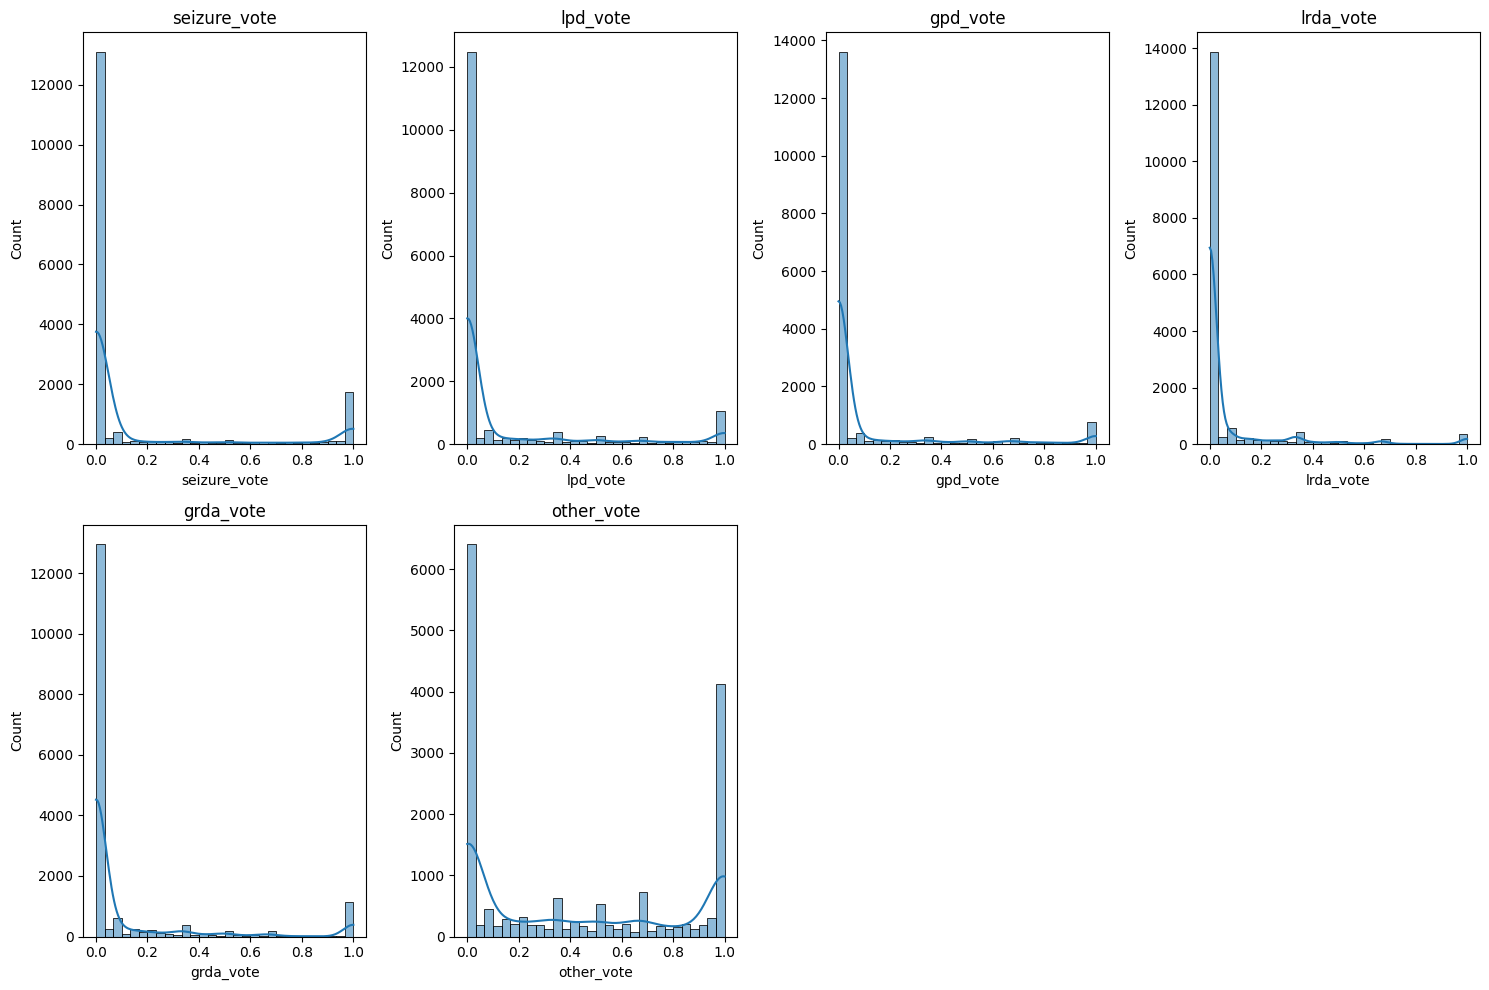

In [9]:
targets = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

plt.figure(figsize=(15, 10))
for i, column in enumerate(targets, 1):
    plt.subplot(2, 4, i)
    sns.histplot(train[column], kde=True, bins=30)
    plt.title(column)
plt.tight_layout()

In [10]:
for feature in targets:
    print('{0}의 와도 {1:0.4f}'.format(feature, train[feature].skew())) #데이터 프레임 내 컬럼을 먼저 입력하고, 그 뒤에 skew나 kurt
    print('{0}의 첨도 {1:0.4f}'.format(feature,train[feature].kurt()))


seizure_vote의 와도 1.9452
seizure_vote의 첨도 2.0266
lpd_vote의 와도 2.0389
lpd_vote의 첨도 2.7467
gpd_vote의 와도 2.5679
gpd_vote의 첨도 5.3327
lrda_vote의 와도 3.5719
lrda_vote의 첨도 13.0794
grda_vote의 와도 2.5111
grda_vote의 첨도 5.0367
other_vote의 와도 0.3276
other_vote의 첨도 -1.5957


In [11]:
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

In [12]:
all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

In [13]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'

In [14]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# FEATURE NAMES
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
FEATURES += [f'eeg_mean_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_min_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_max_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_std_f{x}_10s' for x in range(512)]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

data = np.zeros((len(train),len(FEATURES)))
for k in range(len(train)):
    if k%100==0: print(k,', ',end='')
    row = train.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 

    # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,:400] = x
    x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,800:1200] = x
    x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,1200:1600] = x

    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

train[FEATURES] = data
print(); print('New train shape:',train.shape)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
We are creating 3648 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

In [15]:
# FREE MEMORY
del all_eegs, spectrograms, data
gc.collect()

30138

# CAT BOOST MODEL